In [1]:
import random
import pandas as pd
import os

from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

#from PIL import Image, ImageFilter

import keras.backend as KerasBackend

from skimage.transform import resize

import time


from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras import backend as K
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import ZeroPadding2D
from keras.preprocessing.image import ImageDataGenerator
import keras
# import cv2

import tensorflow as tf
import keras.utils as np_utils


import tqdm

from keras.preprocessing import image
from keras.layers import Lambda
from keras.layers import Concatenate

from keras.callbacks import EarlyStopping
from tqdm import tqdm_notebook as tqdm_NB
import os
import shutil



import skimage.io as io
import skimage.transform as trans



from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

import re

from IPython.core.display import display, HTML


import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

Using TensorFlow backend.


In [2]:
path_train = 'data/train/'
path_test = 'data/test/'

train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]

In [3]:
im_height = 128
im_width = 128
im_chan = 1

# Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_NB(enumerate(train_ids), total=len(train_ids)):
    path = path_train
    img = image.load_img(path + '/images/' + id_)
    x = image.img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = image.img_to_array(image.load_img(path + '/masks/' + id_))[:,:,1]
    Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

print('Done!')

Getting and resizing train images and masks ... 



Done!


In [4]:
#Attempting to Augment X_Train and y_train images.
#Here is a link to the library Documentation:
display(HTML("""<a href="https://augmentor.readthedocs.io/en/master/">Documentation</a>"""))
#I am using an tutorial found here: 
display(HTML("""<a href="https://github.com/mdbloice/Augmentor">Tutorial</a>"""))
import Augmentor

## Image Augmentation:

In [5]:
train_image_path = r"C:\Users\uschlac\Documents\Practicum\Practicum_2\Salt_Deposit_Identification-master\Data\train\images"

train_mask_path = r"C:\Users\uschlac\Documents\Practicum\Practicum_2\Salt_Deposit_Identification-master\Data\train\masks"

p = Augmentor.Pipeline(train_image_path)
# Point to a directory containing ground truth data.
# Images with the same file names will be added as ground truth data
# and augmented in parallel to the original data.
p.ground_truth(train_mask_path)
# Add operations to the pipeline as normal:
p.rotate(probability=1, max_left_rotation=5, max_right_rotation=5)
p.flip_left_right(probability=0.5)
p.zoom_random(probability=0.5, percentage_area=0.8)
p.flip_top_bottom(probability=0.5)

#This function allows you to select how many images you would like to augment.
p.sample(1000)

Initialised with 4000 image(s) found.
Output directory set to C:\Users\uschlac\Documents\Practicum\Practicum_2\Salt_Deposit_Identification-master\Data\train\images\output.

4000 ground truth image(s) found.


Processing <PIL.Image.Image image mode=RGB size=101x101 at 0x191DB4A8>: 100%|██████████| 1000/1000 [00:04<00:00, 206.65 Samples/s]


In [6]:
#All the orginal images being with "images_original_"
#All masks begin with "_groudtruth_(1)_images"

In [7]:
#This takes all the augmentated images and masks and creates places them
# in a two seperate folders into the train directory.
path_train = r'C:\Users\uschlac\Documents\Practicum\Practicum_2\Salt_Deposit_Identification-master\Data\train'
srcpath = str(train_image_path) + r"\output"
destpath = path_train

for root, subFolders, files in os.walk(srcpath):
    for file in files:
        subFolder = os.path.join(destpath, file[:8])
        if not os.path.isdir(subFolder):
            os.makedirs(subFolder)
        shutil.move(os.path.join(root, file), subFolder)

In [8]:
#Renames files in train directory for ease.

#Augmented_Masks:
os.rename(src = str(path_train) + r"/_groundt", dst=str(path_train) + r"/aug_masks")

#Augmented_Images:
os.rename(src = str(path_train) + r"/images_o", dst=str(path_train) + r"/aug_images")

## Import Augmented Images

In [9]:
aug_train_images_ids = next(os.walk(path_train+r"/aug_images"))[2]
aug_train_masks_ids = next(os.walk(path_train+r"/aug_masks"))[2]

In [10]:
im_height = 128
im_width = 128
im_chan = 1

# Get and resize train images and masks
Aug_X_train = np.zeros((len(aug_train_images_ids), im_height, im_width, im_chan), dtype=np.uint8)
Aug_Y_train = np.zeros((len(aug_train_images_ids), im_height, im_width, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_NB(enumerate(aug_train_images_ids), total=len(aug_train_images_ids)):
    path = path_train
    img = image.load_img(path + r'/aug_images/' + id_)
    x = image.img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    Aug_X_train[n] = x
    
for n, id_ in tqdm_NB(enumerate(aug_train_masks_ids), total=len(aug_train_masks_ids)):    
    mask = image.img_to_array(image.load_img(path + r'/aug_masks/' + id_))[:,:,1]
    Aug_Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

print('Done!')

Getting and resizing train images and masks ... 



Done!


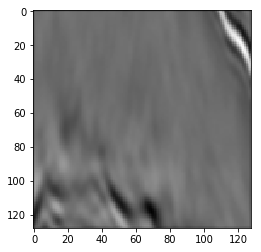

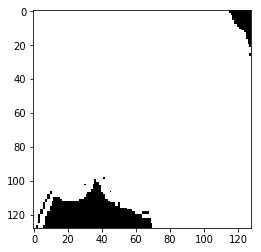

In [11]:
# Check if training data looks all right
ix = random.randint(0, len(Aug_X_train))
plt.imshow(np.dstack((Aug_X_train[ix],Aug_X_train[ix],Aug_X_train[ix])))
plt.show()


tmp = np.squeeze(Aug_Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

## Data Seperation and Labeling:

In [12]:
X_train = np.concatenate((X_train, Aug_X_train), axis=0)
Y_train = np.concatenate((Y_train, Aug_Y_train), axis=0)

In [13]:
# Let's use the first 350 images from our trainset for our test sample.
X_test_out_of_train = X_train[:350]
y_test_out_of_train = Y_train[:350]


X_train_w_aug = X_train[350:]
y_train_w_aug = Y_train[350:]

# Modeling:

In [14]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [15]:
# Build U-Net model
inputs = Input((im_height, im_width, im_chan))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  80          lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [16]:
earlystopper = EarlyStopping(patience=5, verbose=2)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=2, save_best_only=True)
results = model.fit(X_train_w_aug, y_train_w_aug, validation_data=(X_test_out_of_train, y_test_out_of_train),
                    batch_size=8, epochs=10, verbose=2,
                    callbacks=[earlystopper, checkpointer])

Train on 4650 samples, validate on 350 samples
Epoch 1/10
 - 48s - loss: 0.5634 - mean_iou: 0.3747 - val_loss: 0.5701 - val_mean_iou: 0.3752

Epoch 00001: val_loss improved from inf to 0.57014, saving model to model-tgs-salt-1.h5
Epoch 2/10
 - 44s - loss: 0.4451 - mean_iou: 0.3866 - val_loss: 0.3753 - val_mean_iou: 0.4141

Epoch 00002: val_loss improved from 0.57014 to 0.37526, saving model to model-tgs-salt-1.h5
Epoch 3/10
 - 43s - loss: 0.3861 - mean_iou: 0.4348 - val_loss: 0.4281 - val_mean_iou: 0.4541

Epoch 00003: val_loss did not improve from 0.37526
Epoch 4/10
 - 43s - loss: 0.3318 - mean_iou: 0.4750 - val_loss: 0.3118 - val_mean_iou: 0.4948

Epoch 00004: val_loss improved from 0.37526 to 0.31178, saving model to model-tgs-salt-1.h5
Epoch 5/10
 - 43s - loss: 0.3041 - mean_iou: 0.5111 - val_loss: 0.3176 - val_mean_iou: 0.5264

Epoch 00005: val_loss did not improve from 0.31178
Epoch 6/10
 - 43s - loss: 0.2878 - mean_iou: 0.5396 - val_loss: 0.2660 - val_mean_iou: 0.5509

Epoch 000

In [17]:
# Get and resize test images
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm_NB(enumerate(test_ids), total=len(test_ids)):
    path = path_test
    img = image.load_img(path + '/images/' + id_)
    x = image.img_to_array(img)[:,:,1]
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_test[n] = x

print('Done!')

Getting and resizing test images ... 



Done!


In [18]:
# Predict on train, val and test
model = load_model('model-tgs-salt-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=0)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=0)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

18000/18000 [==============================] - ETA: 32 - ETA: 33 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 34 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 33 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 32 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 31 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 30 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA: 29 - ETA

In [19]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in tqdm.tnrange(len(preds_test)):
    # We need to resize the images from 128 x 128 back to 101 x 101 pixels. 
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [20]:
preds_test_upsampled[0].shape

(101, 101)

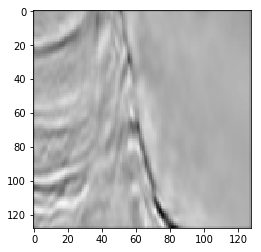

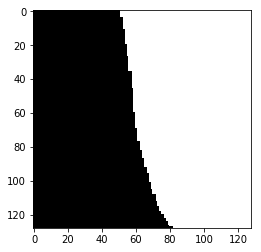

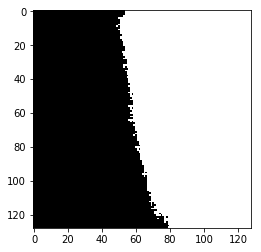

In [21]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()


y_img = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((y_img,y_img,y_img)))
plt.show()


pred_img = np.squeeze(preds_train_t[ix]).astype(np.float32)
plt.imshow(np.dstack((pred_img,pred_img,pred_img)))
plt.show()

In [22]:
def RLenc(img, order='F', format=True):
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in tqdm_NB(enumerate(test_ids))}

In [23]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')